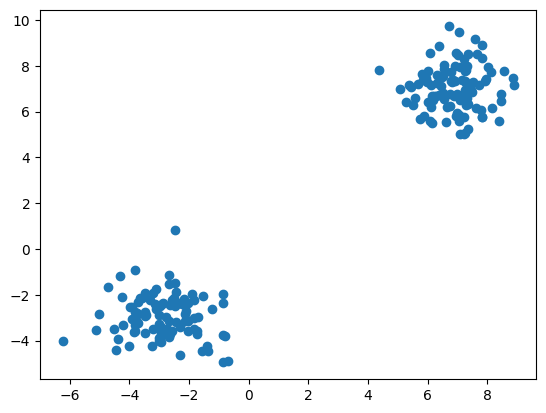

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 真實數據
np.random.seed(42)
data1 = np.random.randn(100, 2) + np.array([7, 7])
data2 = np.random.randn(100, 2) + np.array([-3, -3])
real_data = np.vstack([data1, data2])

# 繪制真實數據
plt.scatter(real_data[:, 0], real_data[:, 1])
plt.show()

# 原始數據轉tensor
real_data = torch.as_tensor(real_data, dtype=torch.float32)

# 生成真實數據的標籤
real_labels = torch.zeros(200, dtype=torch.long)
real_labels[:100] = 0  # 前一百筆是第一類別 (7, 7)
real_labels[100:] = 1  # 後一百筆是第二類別 (-3, -3)

## INFO-GAN 實作

In [4]:
# 定義生成器
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(2, 2)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim)
        )

    def forward(self, noise, labels):
        label_embed = self.label_embedding(labels)  # 嵌入標籤
        gen_input = torch.cat((noise, label_embed), dim=-1)  # 將噪聲和嵌入的標籤連接起來
        return self.model(gen_input)

# 定義鑑別器
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 定義輔助網路
class AuxiliaryNetwork(nn.Module):
    def __init__(self, input_dim, label_dim, continuous_dim):
        super(AuxiliaryNetwork, self).__init__()
        self.label_dim = label_dim
        self.continuous_dim = continuous_dim
        self.label_model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, label_dim),
            nn.Softmax(dim=1)
        )
        self.continuous_model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, continuous_dim * 2)  # Output both mean and variance
        )

    def forward(self, x):
        label_output = self.label_model(x)
        continuous_output = self.continuous_model(x)
        mean, log_var = torch.chunk(continuous_output, 2, dim=1)
        var = torch.exp(log_var)
        return label_output, mean, var

In [5]:
# 訓練模型
# 設置參數
noise_dim = 100
label_dim = 2
output_dim = 2
continuous_dim = 2
num_epochs = 20000
batch_size = 64
lr = 0.001

# 初始化模型
generator = Generator(noise_dim, label_dim, output_dim)
discriminator = Discriminator(output_dim)
auxiliary = AuxiliaryNetwork(output_dim, label_dim, continuous_dim)

# 設置優化器
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
a_optimizer = torch.optim.Adam(auxiliary.parameters(), lr=lr, betas=(0.5, 0.999))

# 損失函數
adversarial_loss = nn.BCELoss()
continuous_loss = nn.GaussianNLLLoss()
categorical_loss = nn.CrossEntropyLoss()

# 訓練 Info-GAN
for epoch in range(num_epochs):
    # 隨機抽取一個小批量的真實數據
    idx = np.random.randint(0, real_data.size(0), batch_size)
    real_samples = real_data[idx]
    
    # 生成label
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
    
    # 訓練鑑別器
    noise = torch.randn(batch_size, noise_dim)
    
    # 生成隨機標籤
    random_labels = torch.randint(0, label_dim, (batch_size,))
    
    # 生成數據
    fake_samples = generator(noise, random_labels)
    
    # 計算判別器對真實數據跟生成數據的損失
    real_loss = adversarial_loss(discriminator(real_samples), real_labels)
    fake_loss = adversarial_loss(discriminator(fake_samples.detach()), fake_labels)
    d_loss = (real_loss + fake_loss) / 2

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # 訓練生成器
    g_optimizer.zero_grad()
    a_optimizer.zero_grad()
    
    g_loss = adversarial_loss(discriminator(fake_samples), real_labels)

    # 訓練輔助網絡
    pred_labels, pred_mean, pred_var = auxiliary(fake_samples.detach())
    con_loss = continuous_loss(pred_mean, random_labels.unsqueeze(1).float(), pred_var)
    cat_loss = categorical_loss(pred_labels, random_labels)
    a_loss = (con_loss + cat_loss) / 2
    
    (g_loss + a_loss).backward()
    
    g_optimizer.step()
    a_optimizer.step()

    # 每1000次打印訓練數據
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], g_loss: {:.4f}, d_loss: {:.4f}, a_loss: {:.4f}'.format(epoch+1, num_epochs, g_loss.item(), d_loss.item(), a_loss.item()))

Epoch [1000/20000], g_loss: 0.7113, d_loss: 0.7794, a_loss: -0.5514
Epoch [2000/20000], g_loss: 0.7809, d_loss: 0.6628, a_loss: -0.8332
Epoch [3000/20000], g_loss: 0.7050, d_loss: 0.6844, a_loss: -0.6734
Epoch [4000/20000], g_loss: 0.6471, d_loss: 0.7494, a_loss: -1.2961
Epoch [5000/20000], g_loss: 0.6904, d_loss: 0.6954, a_loss: -1.3220
Epoch [6000/20000], g_loss: 0.6856, d_loss: 0.6833, a_loss: -0.8485
Epoch [7000/20000], g_loss: 0.6996, d_loss: 0.7008, a_loss: -1.3105
Epoch [8000/20000], g_loss: 0.7157, d_loss: 0.6961, a_loss: -1.1081
Epoch [9000/20000], g_loss: 0.7234, d_loss: 0.6912, a_loss: -1.4674
Epoch [10000/20000], g_loss: 0.6925, d_loss: 0.6932, a_loss: -1.5295
Epoch [11000/20000], g_loss: 0.7270, d_loss: 0.6934, a_loss: -1.1723
Epoch [12000/20000], g_loss: 0.6959, d_loss: 0.6944, a_loss: -1.3787
Epoch [13000/20000], g_loss: 0.6864, d_loss: 0.6942, a_loss: -1.1841
Epoch [14000/20000], g_loss: 0.6971, d_loss: 0.6884, a_loss: -1.3326
Epoch [15000/20000], g_loss: 0.7014, d_loss

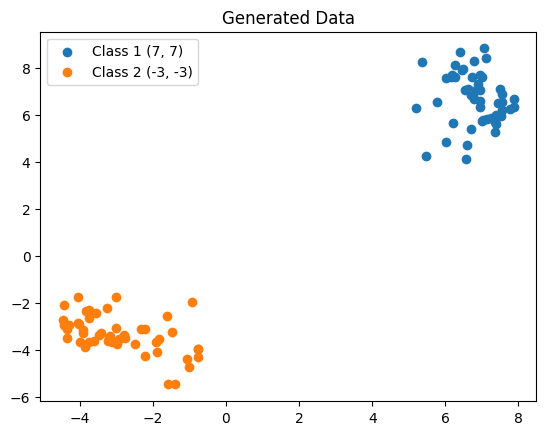

In [10]:
# 生成數據
generator.eval()
noise = torch.randn(100, noise_dim)
labels = torch.zeros(100, dtype=torch.long)  # 使用整數標籤
labels[:50] = 1  # 第一類別 (7,7)
labels[50:] = 0  # 第二類別 (-3,-3)

generated_samples = generator(noise, labels).detach().numpy()

# 印出x軸跟y軸的資料
plt.scatter(generated_samples[:50, 0], generated_samples[:50, 1], label='Class 1 (7, 7)')
plt.scatter(generated_samples[50:, 0], generated_samples[50:, 1], label='Class 2 (-3, -3)')
plt.legend()
plt.title("Generated Data")
plt.show()